# Laboratorio di Simulazione Numerica: lezione 12

Elia Steve (47122A)

In [133]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from PIL import Image
seed=42
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

### Esercizio 12.1

In questo esercizio dobbiamo addestrare una rete neurale profonda al riconoscimento di cifre scritte a mano usando il database MNIST. Cominciamo caricando i dati e processandoli (i dati vanno linearizzati per l'utilizzo con la rete neurale, e le etichette covertite per essere usate con l'output della rete, che è una distribuzione di probabilità sulle cifre possibili).

In [134]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 5


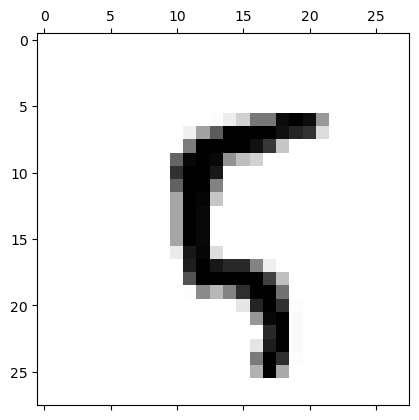

... and with label [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [135]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[100])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[100,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[100], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

Ora scriviamo una funzione che crei il modello, con le seguenti caratteristiche:

* per ora usiamo semplicemente livelli densi standard;
* inseriamo uno strato di dropout, che ad ogni iterazione di training sceglie metà dei propri input e li pone uguali a zero, al fine di prevenire l'overtraining. Con l'aggiunta di questo strato è tipico che la rete abbia una performance migliore in vase di validazione, dove tutti i neuroni sono attivi, che in fase di training.
* L'utlimo strato contiene 10 neuroni, e usa come funzione di attivazione la softmax, in modo che l'output sia interpretabile come una distribuzione di probabilità sulle possibli cifre.

In [136]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    """
    Creates a deep neural network for use with the MNIST database.
    """
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

Definiamo anche una funzione che compili il modello dato un ottimizzatore (visto che in questo esercizio ne proveremo di diversi). In tutti i casi scegliamo di usare la l'entropia incrociata (_cross-entropy_) come funzione di costo.

In [137]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam

def compile_model(optimizer, creation_function):
    # create the model
    model=creation_function()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['acc'])
    return model

Ora definiamo delle funzioni utili per addestrare un modello e valutarne la performance.

In [138]:
# training parameters
batch_size = 32
epochs = 50 #"Non presentatemi 5 epoche per un problema che deve imparare da 60k immagini"

In [139]:
def define_train_model(
    creation_function, 
    optimizer,
    model_filename,
    history_filename,
    batch_size,
    epochs
):
    """
    Looks for a trained model and its history as files. If they are not present, creates
    and trains a model using the provided model creation function, and saves it and its history
    to file.

    Args:
        creation_function: function which creates a model. Takes no arguments.
        optimizer: Optimizer for model training
        model_filename: filename for the model. The function first looks for a file with this
          filename on disk. If it is not present, a new model is created and trained, and then
          saved to file with this name.
        history_filename: filename for the model history. Same behaviour as for the model filename.
        batch_size: batch size for training
        epochs: training epochs

    Returns:
        model: the trained model
        history: training history
    """
    if os.path.isfile(model_filename) and os.path.isfile(history_filename):
        model = keras.models.load_model(model_filename)
        with open(history_filename, "rb") as f:
            history = pickle.load(f)
    else:
        # create the deep neural net
        model = compile_model(optimizer, creation_function)
        
        # train DNN and store training info in history
        history = model.fit(X_train, Y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(X_test, Y_test))
        model.save(model_filename)
        with open(history_filename, "wb") as f:
            pickle.dump(history, f)

    return model, history

In [140]:
def print_history_and_evaluation(score, history, title):
    """
    Plots various metrics for the model and the score from evaluation on the trainig data

    Args:
        score: score from model evaluation
        history: training history for the model
        title: global title of the plot
    """
    
    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    # summarize history for accuracy
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(6.4, 7.2), sharex=True)
    
    ax_top.plot(history.history['acc'])
    ax_top.plot(history.history['val_acc'])
    ax_top.set_ylabel('Accuratezza')
    ax_top.legend(['Training', 'Validazione'], loc='best')
    ax_top.grid()
    
    # summarize history for loss
    ax_bottom.plot(history.history['loss'])
    ax_bottom.plot(history.history['val_loss'])
    ax_bottom.set_xlabel('Epoca')
    ax_bottom.set_ylabel('Funzione costo (cross-entropy)')
    ax_bottom.legend(['Training', 'Validazione'], loc='best')
    ax_bottom.grid()

    fig.suptitle(title)
    plt.show()

In [141]:
def predict(model, X_test, Y_test):
    """
    Computes neural network prediction for the validation data, outputs them together with
    images of the digits for the first 10 elements.

    Args:
        model: trained model for prediction making
        X_test: validation data
        Y_test: labels for validaton data
    """
    predictions = model.predict(X_test)
    
    plt.figure(figsize=(15, 15)) 
    for i in range(10):    
        ax = plt.subplot(2, 10, i + 1)    
        plt.imshow(X_test.reshape(X_test.shape[0], img_rows, img_cols,1)[i, :, :, 0], cmap='gray')    
        plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
        plt.axis('off') 
    plt.show()

Definiamo, addestriamo un modello usndo la discesa stocastica del gradiente:

In [142]:
model_DNN, history = define_train_model(
    create_DNN,
    SGD(),
    "model_DNN_SGD.keras",
    "history_SGD",
    batch_size,
    epochs
)

Valutiamo il modello:

313/313 [==============================] - 1s 2ms/step - loss: 0.0592 - acc: 0.9823

Test loss: 0.05915742740035057
Test accuracy: 0.9822999835014343


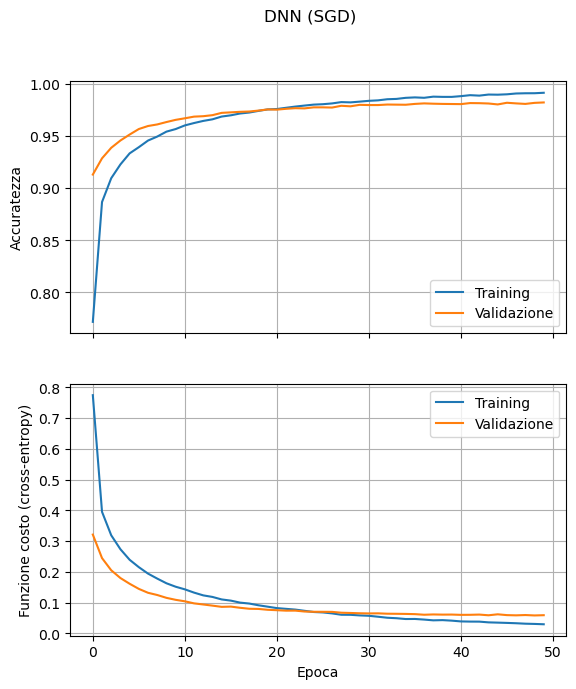

In [143]:
score_DNN = model_DNN.evaluate(X_test, Y_test, verbose=1)
print_history_and_evaluation(score_DNN, history, "DNN (SGD)")

313/313 [==============================] - 1s 2ms/step


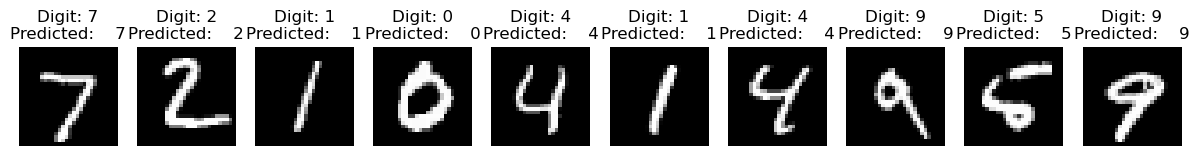

In [144]:
predict(model_DNN, X_test, Y_test)

Osserviamo che per circa le prime 20 iterazioni il modello ha performance migliore sui dati di validazione che su quelli di training: questo comportamento probabilmente è una conseguenza di aver usato uno strato di dropout.

Ora usiamo Adagrad per ottimizzare il modello:

In [145]:
model_DNN_Adagrad, history_Adagrad = define_train_model(
    create_DNN,
    Adagrad(),
    "model_DNN_Adagrad.keras",
    "history_Adagrad",
    batch_size,
    epochs
)

Valutiamo il modello:

313/313 [==============================] - 1s 2ms/step - loss: 0.1478 - acc: 0.9558

Test loss: 0.1477518379688263
Test accuracy: 0.9557999968528748


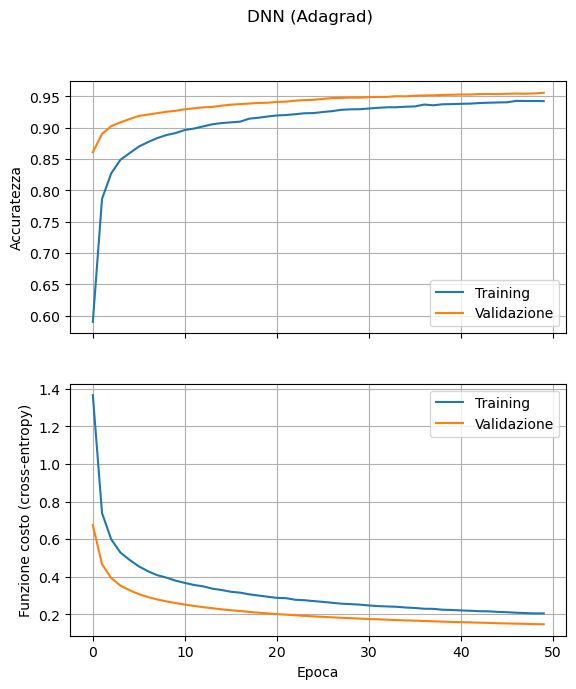

In [146]:
#evaluate(model_DNN_Adagrad, history_Adagrad)
score_DNN_Adagrad = model_DNN_Adagrad.evaluate(X_test, Y_test, verbose=1)
print_history_and_evaluation(score_DNN_Adagrad, history_Adagrad, "DNN (Adagrad)")

313/313 [==============================] - 1s 2ms/step


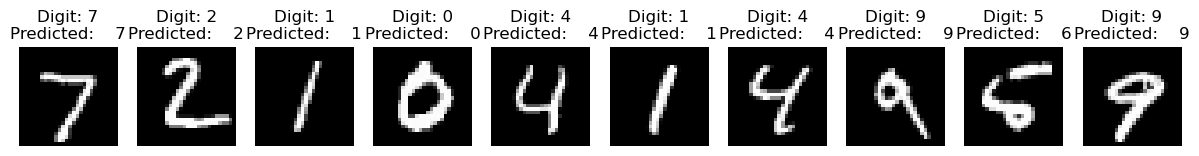

In [147]:
predict(model_DNN_Adagrad, X_test, Y_test)

Il modello addestrato con Adagrad ha performance inferiori rispetto al precedente: notiamo anche ancora che il modello ha performance migliori sui dati di training durante tutta l'ottimizzazione, segno probabilmente che la soluzione alla fine delle 50 epoche non è arrivata a convergenza.

Ora addestriamo il modello con Adam:

In [148]:
model_DNN_Adam, history_Adam = define_train_model(
    create_DNN,
    Adam(),
    "model_DNN_Adam.keras",
    "history_Adam",
    batch_size,
    epochs
)

Valutiamo il modello:

313/313 [==============================] - 1s 2ms/step - loss: 0.0621 - acc: 0.9830

Test loss: 0.06211831048130989
Test accuracy: 0.9829999804496765


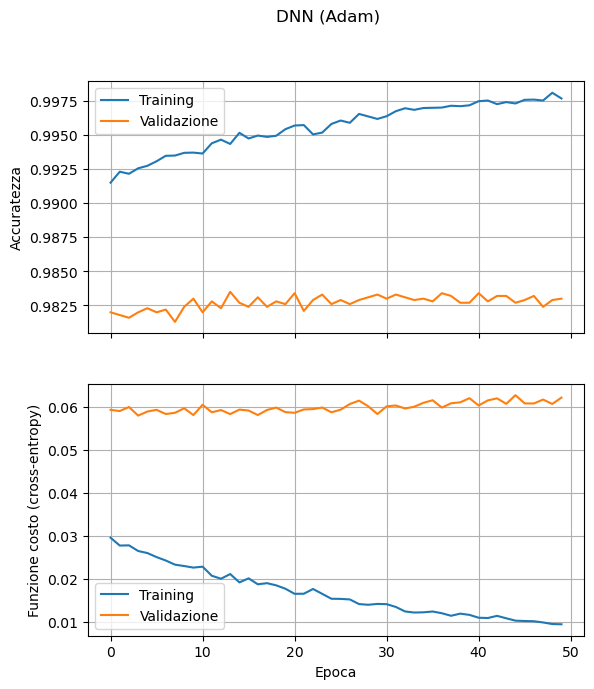

In [149]:
score_DNN_Adam = model_DNN_Adam.evaluate(X_test, Y_test, verbose=1)
print_history_and_evaluation(score_DNN_Adam, history_Adam, "DNN (Adam)")

313/313 [==============================] - 1s 2ms/step


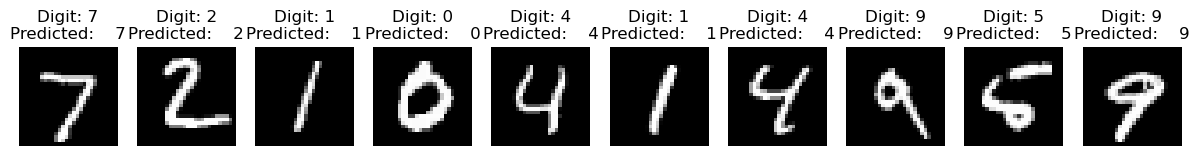

In [150]:
predict(model_DNN_Adam, X_test, Y_test)

Qui osserviamo che il modello ha funzione di costo più grande di quello addestrato con la discesa stocastica del gradiente, ma l'accuratezza è migliore: questo fatto illustra che è bene tenere traccia di più di una metrica per valutare le prestazioni di un modello. Vediamo inoltre che qui il modello ha prestazioni migliori sui dati di training, coerentemente con quanto ci si aspetta in generale.

### Esercizio 12.2

In questo esercizio dobbiamo affrontare lo stesso problema del riconoscimento delle cifre del database del MNIST, ma usando una rete neurale convoluzionale. Per cominciare processiamo i dati (le cifre adesso devono essere in forma matriciale).

In [151]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


Definiamo una funzione per creare la rete. Ho scelto di:

* iniziare la rete con due strati di convoluzione e due strati di _max pooling_;
* successivamente inserire due strati densi;
* inserire uno strato di dropout con le stesse probabilità del caso precedente;
* usare come funzione di attivazione per l'ultimo strato la softmax, come nel caso precedente.

In [152]:
#THIS IS INCOMPLETE ... COMPLETE BEFORE EXECUTING IT

def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    #
    # ADD HERE SOME OTHER LAYERS AT YOUR WILL, FOR EXAMPLE SOME: Dropout, 2D pooling, 2D convolutional etc. ... 
    # remember to move towards a standard flat layer in the final part of your DNN,
    # and that we need a soft-max layer with num_classes=10 possible outputs
    #

    model.add(MaxPooling2D())
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(25, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

Confrontiamo la rete convoluzioanale con quella precedente:

In [153]:
model_DNN.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 400)               314000    
                                                                 
 dense_28 (Dense)            (None, 100)               40100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 10)                1010      
                                                                 
Total params: 355,110
Trainable params: 355,110
Non-trainable params: 0
_________________________________________________________________


In [154]:
model_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 10)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 10)          2510      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 10)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 160)               0         
                                                                 
 dense_9 (Dense)             (None, 100)              

Addestriamo il modello. Ho scelto di usare Adam, l'ottimizzatore che nell'esercizio precedente dava la migliore accuratezza, e di addestrare il modello per 20 epoche (una precedente versione ne usava 50, ma nelle ulteriori 30 epoche non ho riscontrato miglioramenti significativi nell'accuratezza).

In [155]:
model_CNN, history_CNN = define_train_model(
    create_CNN,
    Adam(),
    "model_CNN_Adam.keras",
    "history_CNN_Adam",
    batch_size,
    20
)

Valutiamo il modello:

313/313 [==============================] - 2s 4ms/step - loss: 0.0646 - acc: 0.9904

Test loss: 0.0645846575498581
Test accuracy: 0.9904000163078308


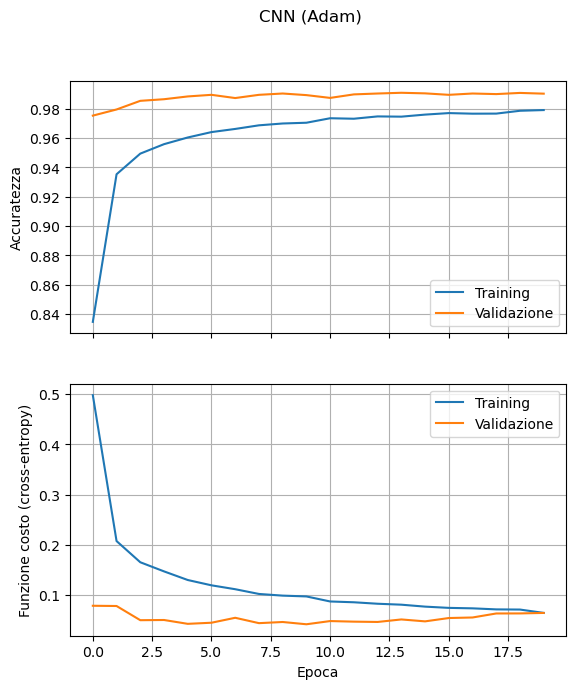

In [156]:
#evaluate(model_CNN, history_CNN)
score_CNN = model_CNN.evaluate(X_test, Y_test, verbose=1)
print_history_and_evaluation(score_CNN, history_CNN, "CNN (Adam)")

313/313 [==============================] - 2s 5ms/step


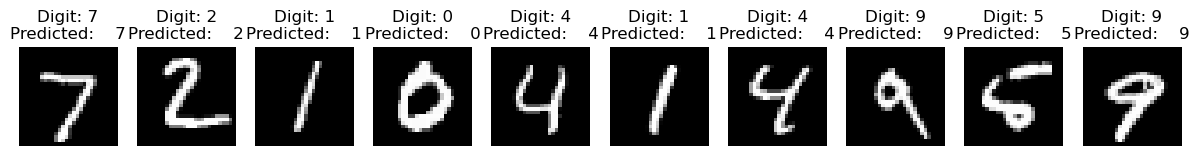

In [157]:
predict(model_CNN, X_test, Y_test)

Otteniamo accuratezza migliore di tutti i casi precedenti, a fronte di un dispendio significativamente minore di risorse (~20000 parametri contro ~350000, e meno epoche di training). Osserviamo anche che:

* le prestazioni del modello sono migliori sui dati di validazione per tutte le epoche di training;
* osservando il grafico della funzione costo sembrerebbe che si sia verificato overtraining, ma in realtà l'accuratezza del modello migliora o rimane costante per tutto l'addestramento. Questo fatto illustra nuovamente la necessità di tenere traccia di più metriche per valutare le prestazioni di un modello.

### Esercizio 12.3

In questo esercizio dobbiamo usare la rete neurale convoluzionale che abbiamo addestrato nell'esercizio precedente per provare a classificare le cifre della mia scrittura. Creo una funzione per importare una cifra e predirne il valore:

In [158]:
def import_predict_digit(filename, model):
    """
    Imports a handwritten digit from file and predicts its value using a CNN.

    Args:
        filename: name of the file containing the digit
        model: model for predicting the value of the digit
    """
    digit_in = Image.open(filename).convert("L")
    ydim, xdim = digit_in.size
    pix = digit_in.load()
    
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]
    data /= 255
    
    data = data.reshape(1,xdim,ydim,1)
    pred_0 = model.predict(data)
    data = data.reshape(xdim,ydim)
    
    plt.figure(figsize=(5, 5))  
    plt.imshow(data, cmap='gray')    
    plt.title("Digit predicted:    {}".format(np.argmax(pred_0)))
    print(pred_0)
    plt.axis('off') 
    plt.show()

Predico i valori delle cifre:

1/1 [==============================] - 0s 31ms/step
[[1.0000000e+00 1.2746721e-34 1.4059825e-15 7.6133352e-19 1.9426199e-34
  1.0775599e-23 5.5459609e-15 4.1520515e-31 1.7504946e-15 0.0000000e+00]]


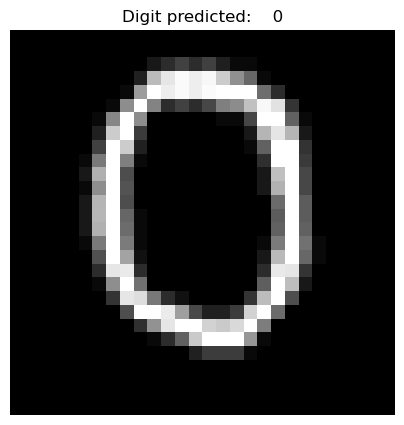

1/1 [==============================] - 0s 29ms/step
[[6.3513530e-36 1.0000000e+00 3.7555046e-12 1.4356530e-19 2.9138666e-30
  1.8318490e-26 2.2077034e-25 2.0677854e-12 1.5795771e-15 0.0000000e+00]]


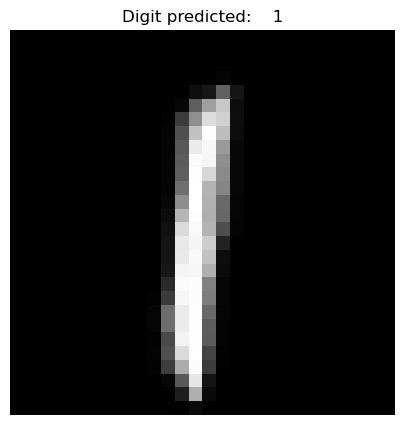

1/1 [==============================] - 0s 25ms/step
[[2.3272953e-24 8.0242808e-26 1.0000000e+00 3.7314848e-16 6.0660225e-24
  4.3083260e-28 1.0812941e-24 9.2824455e-18 1.9983110e-12 2.8731222e-33]]


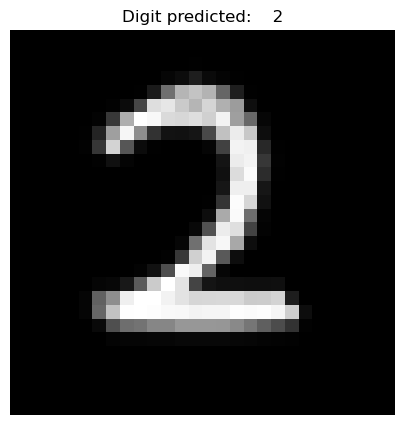

1/1 [==============================] - 0s 24ms/step
[[1.4168088e-24 2.9472975e-19 2.6245705e-13 1.0000000e+00 1.2168572e-27
  1.6599229e-11 3.6955399e-27 4.1925395e-17 1.2398474e-12 1.0845317e-26]]


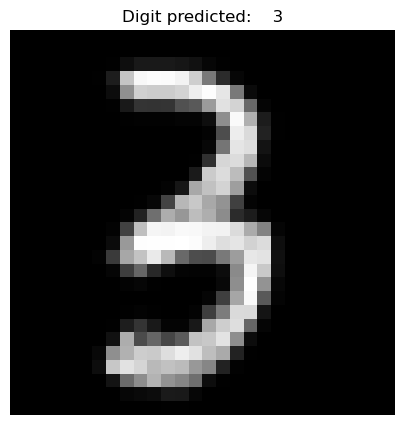

1/1 [==============================] - 0s 25ms/step
[[5.2891365e-11 6.9774508e-08 1.2672630e-05 1.0696263e-09 9.9997306e-01
  1.6414509e-11 6.6699677e-08 1.9199826e-09 7.4032305e-06 6.7017336e-06]]


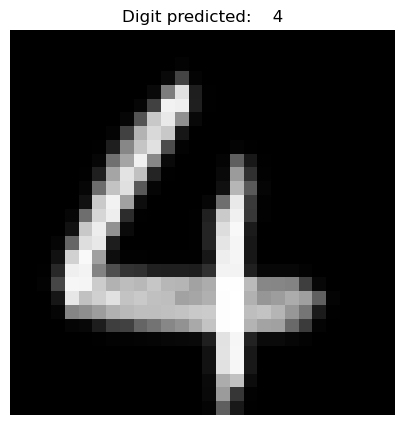

1/1 [==============================] - 0s 33ms/step
[[3.83209686e-13 6.08261506e-17 7.13575429e-17 6.61965532e-05
  1.91086480e-17 9.99931931e-01 1.04046764e-10 9.43093018e-18
  1.95667735e-06 1.56296698e-10]]


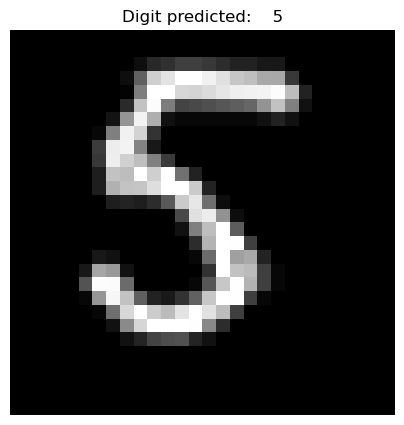

1/1 [==============================] - 0s 28ms/step
[[1.5521153e-05 1.1096086e-05 8.5894335e-06 7.0786341e-03 2.6712814e-06
  5.4704744e-01 1.2041783e-03 5.1288966e-06 4.4421443e-01 4.1223975e-04]]


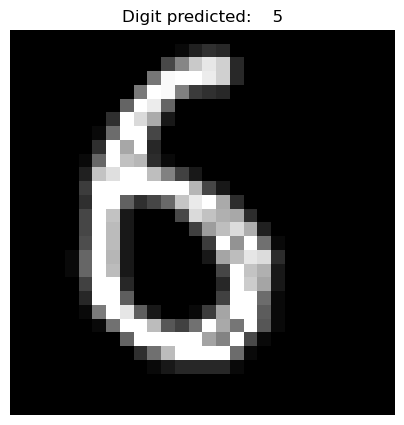

1/1 [==============================] - 0s 28ms/step
[[7.85803931e-13 2.44677503e-04 3.24517860e-05 1.43403716e-08
  2.08618908e-12 3.07700324e-11 1.51525528e-11 9.99722779e-01
  1.16068485e-07 4.25091311e-14]]


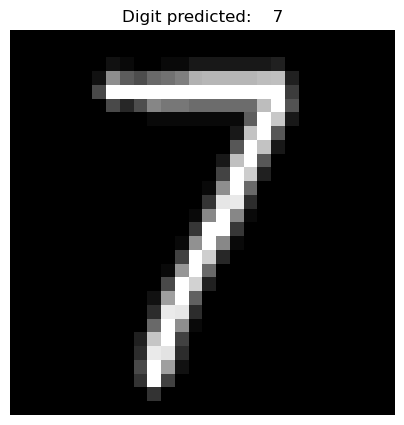

1/1 [==============================] - 0s 31ms/step
[[5.2848109e-15 2.0329530e-12 1.7575648e-10 2.3161459e-08 4.7095462e-14
  2.5241311e-09 1.3294045e-11 2.9944933e-15 1.0000000e+00 5.2554193e-15]]


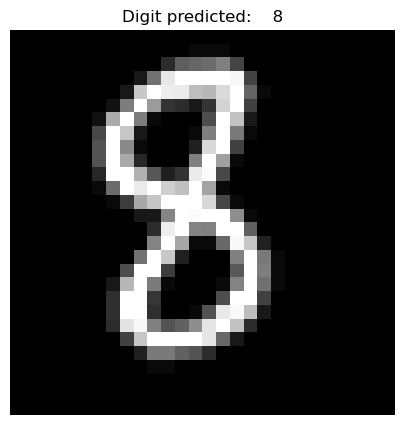

1/1 [==============================] - 0s 31ms/step
[[7.2648622e-06 1.9036852e-05 5.2364483e-03 5.0508539e-04 5.9348164e-04
  2.3296583e-07 1.1695231e-08 9.3302661e-01 7.0651886e-03 5.3546723e-02]]


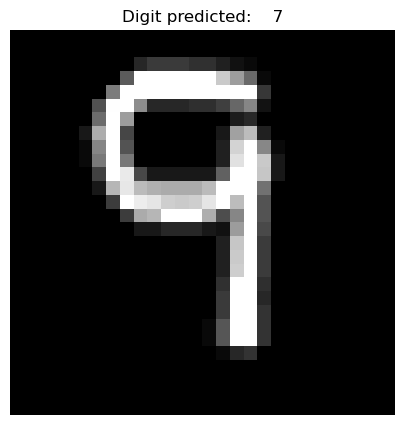

In [159]:
for i in range(10):
    import_predict_digit("handwritten_digits/" + str(i) + ".png", model_CNN)

Le previsioni sono discrete ma non ottime (8 cifre su 10 identificate correttamente): questo probabilmente è imputabile alla differenza della mia grafia da quelle delle cifre nel database MNIST.